In [1]:
import torch, torchvision
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
import os

In [4]:
from torchvision import transforms

In [5]:
from torchvision.io import read_image

In [6]:
import matplotlib.image as mpimg

In [7]:
dataset_info_file_path = '/home/user/Desktop/NNPhotomath/dataSets/aida_classification/dataset_info.csv'

In [8]:
df_dataset_file = pandas.read_csv(dataset_info_file_path)

In [9]:
df_dataset_file

,char_img,label
0,1/\frac_100.jpg,0
1,1/\frac_101.jpg,0
2,1/\frac_102.jpg,0
3,1/\frac_103.jpg,0
4,1/\frac_104.jpg,0
...,...,...
824995,226/empty_9995.jpg,54
824996,226/empty_9996.jpg,54
824997,226/empty_9997.jpg,54
824998,226/empty_9998.jpg,54


In [10]:
dataset_path = '/home/user/Desktop/NNPhotomath/dataSets/aida_classification/'

In [11]:
torch.cuda.is_available()

True

In [12]:
torch.cuda.memory_allocated()

0

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image.type(torch.FloatTensor)/255.
        
        ###Нормализация
        # img_std, img_mean = torch.std_mean(image)
        # image = torchvision.transforms.functional.normalize(image, img_mean, img_std)
        # ###
        
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label) 
            
        return image, label

In [14]:
dataset = CustomImageDataset(df_dataset_file, dataset_path,
                             target_transform=torchvision.transforms.Compose([
                                 lambda x:torch.LongTensor([x]), # or just torch.tensor
                                 lambda x:F.one_hot(x,55)]))

In [15]:
GPU = torch.device('cuda')

In [16]:
generator1 = torch.Generator().manual_seed(20)
train, val, test = torch.utils.data.random_split(dataset, [0.8,0.1,0.1], generator=generator1)

In [17]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64, 1, 55])


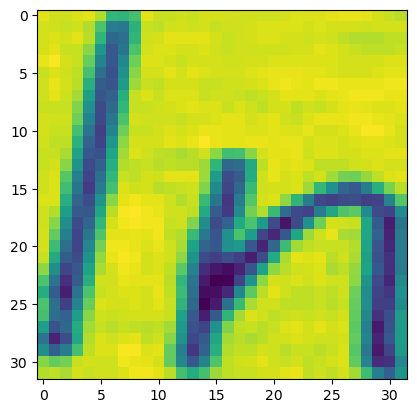

Label: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]])


In [230]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img[0])
plt.show()
print(f"Label: {label}")

In [29]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super(MyNeuralNet, self).__init__()
        
        self.l1 = nn.Conv2d(3,256,kernel_size=3,stride=1,padding=1)
        self.l2 = nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1)
        self.l3 = nn.Flatten()
        self.l4 = nn.Linear(8192, 512)
        self.l5 = nn.Linear(512, 55)
        
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.l1(x)),2)
        x = F.max_pool2d(F.relu(self.l2(x)),2)
        x = self.l3(x)
        x = F.relu(self.l4(x))
        x = self.l5(x)
        
        return F.log_softmax(x, dim=1)

In [39]:
model = MyNeuralNet().to(GPU)

In [40]:
train_features.shape

torch.Size([64, 3, 32, 32])

In [41]:
ans = model(train_features.to(GPU))

In [44]:
train_labels.view([-1,55]).type(torch.FloatTensor).shape

torch.Size([64, 55])

In [45]:
def save_checkpoint(state, filename='nnPhotomath.pth.tar'):
    print('-----Saving best model------')
    torch.save(state, filename)

In [46]:
def train_model(dl, model):
    
    optim = Adam(model.parameters(), lr=0.0001)
    loss = nn.CrossEntropyLoss()
    
    losses = []
    epoches = []
    
    # global train_dataloader
    # train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
    global val_dataloader
    global test_dataloader
    
    
    N = len(dl)
    print(f'N:', N)
    
    val_loss = 0
    val_losses = []
    best_val_loss = 1
    
    test_losses = []
    for i, (x,y) in enumerate(dl):
        x,y = x.to(GPU), y.to(GPU)
        optim.zero_grad()
        loss_val = loss(model(x), y.view([-1,55]).type(torch.FloatTensor).to(GPU))
        loss_val.backward()
        optim.step()

        losses.append([i,loss_val.item()])
        
        val_features, val_labels = next(iter(val_dataloader))
        val_features, val_labels = val_features.to(GPU), val_labels.to(GPU)
        val_loss = loss(model(val_features), val_labels.view([-1,55]).type(torch.FloatTensor).to(GPU))
                        
        val_losses.append([i,val_loss.item()])
                        
        if i%10 == 0:
            print('step:', losses[-1][0], 'Loss:', losses[-1][1])
        
        if best_val_loss > val_loss.item():
            best_val_loss = val_loss.item()
            print('new best val_loss:', best_val_loss)
            save_checkpoint({'state_dict': model.state_dict()})
                        
            test_features, test_labels = next(iter(test_dataloader))
            test_features, test_labels = test_features.to(GPU), test_labels.to(GPU)
            test_loss = loss(model(test_features), test_labels.view([-1,55]).type(torch.FloatTensor).to(GPU))
            test_losses.append([i, test_loss.item()])
    
    return losses, val_losses, test_losses

In [47]:
all_losses = train_model(train_dataloader, model)

N: 10313
step: 0 Loss: 4.010457992553711
step: 10 Loss: 4.019743919372559
step: 20 Loss: 3.981400489807129
step: 30 Loss: 3.9548263549804688
step: 40 Loss: 3.983067035675049
step: 50 Loss: 3.9591355323791504
step: 60 Loss: 3.8099310398101807
step: 70 Loss: 3.8033955097198486
step: 80 Loss: 3.7925198078155518
step: 90 Loss: 3.7238922119140625
step: 100 Loss: 3.6053528785705566
step: 110 Loss: 3.345097064971924
step: 120 Loss: 3.2056753635406494
step: 130 Loss: 3.102688789367676
step: 140 Loss: 2.8770437240600586
step: 150 Loss: 2.572521209716797
step: 160 Loss: 2.326414108276367
step: 170 Loss: 2.233243703842163
step: 180 Loss: 2.076526641845703
step: 190 Loss: 2.27013897895813
step: 200 Loss: 1.8958182334899902
step: 210 Loss: 1.9296462535858154
step: 220 Loss: 1.6721311807632446
step: 230 Loss: 1.6955442428588867
step: 240 Loss: 1.6009573936462402
step: 250 Loss: 1.4578684568405151
step: 260 Loss: 1.8781120777130127
step: 270 Loss: 1.9870240688323975
step: 280 Loss: 1.639444351196289


In [85]:
def reshape(losses):
    x, y = [], []
    for i in losses:
        x.append(i[0])
        y.append(i[1])
        
    return [x,y]

In [86]:
train_losses = reshape(all_losses[0])
val_losses = reshape(all_losses[1])
test_losses = reshape(all_losses[2])

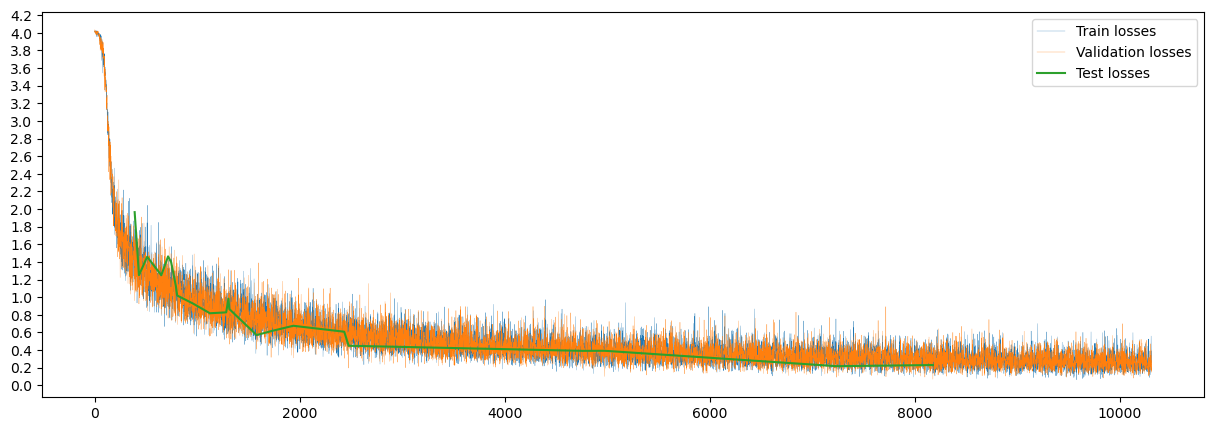

In [105]:
plt.figure(figsize=(15,5))
plt.yticks(np.arange(0, 5, .2))
plt.plot(train_losses[0], train_losses[1], label = "Train losses",linewidth=.2)
plt.plot(val_losses[0], val_losses[1], label = "Validation losses",linewidth=.2)
plt.plot(test_losses[0], test_losses[1], label = "Test losses")
plt.legend()
plt.show()

In [182]:
btch_size = 100

In [183]:
test_dataloader = DataLoader(test, batch_size=btch_size, shuffle=True)

In [216]:
test_features, test_labels = next(iter(test_dataloader))
test_features, test_labels = test_features.to(GPU), test_labels.to(GPU)

results = model.forward(test_features)

In [217]:
test_loss = F.cross_entropy(model(test_features), test_labels.view([-1,55]).type(torch.FloatTensor).to(GPU))

In [218]:
accuracy = 0
for i in range(btch_size):
    if torch.argmax(results[i]) == torch.argmax(test_labels[i].view([-1,55]).type(torch.FloatTensor).to(GPU)):
        accuracy += 1
        
print(accuracy/btch_size)u

0.95


In [208]:
amount_examples_chars = {'\\frac': 0,
 'x': 0,
 '\\to': 0,
 'u': 0,
 '\\lim': 0,
 'c': 0,
 'h': 0,
 '8': 0,
 '\\theta': 0,
 'g': 0,
 '\\right)': 0,
 '=': 0,
 '2': 0,
 '4': 0,
 '\\tan': 0,
 '\\pi': 0,
 '+': 0,
 '': 0,
 'y': 0,
 'p': 0,
 '\\sin': 0,
 '7': 0,
 'k': 0,
 '\\cot': 0,
 '6': 0,
 '-': 0,
 'd': 0,
 'w': 0,
 '0': 0,
 '\\right|': 0,
 '\\log': 0,
 '\\left(': 0,
 'v': 0,
 '9': 0,
 '1': 0,
 '3': 0,
 '\\ln': 0,
 '\\cos': 0,
 'a': 0,
 'z': 0,
 '\\sqrt': 0,
 'b': 0,
 '5': 0,
 's': 0,
 't': 0,
 'r': 0,
 '\\infty': 0,
 '\\csc': 0,
 'e': 0,
 'n': 0,
 '\\sec': 0,
 '\\cdot': 0,
 '\\left|': 0,
 '.': 0,
 'empty': 0} 

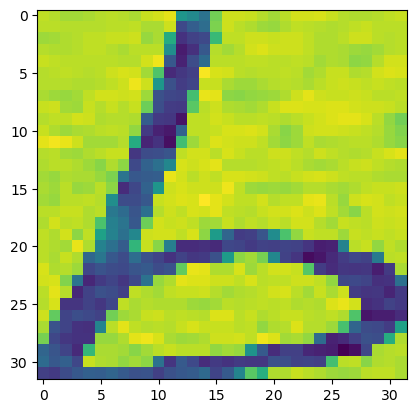

Label: b
Right label: b


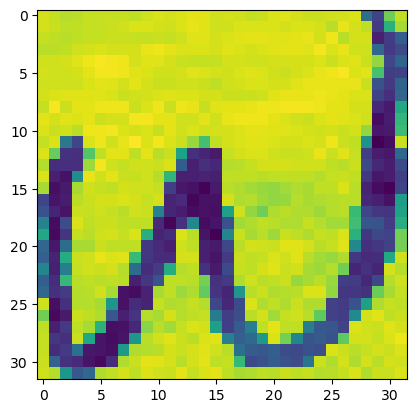

Label: w
Right label: w


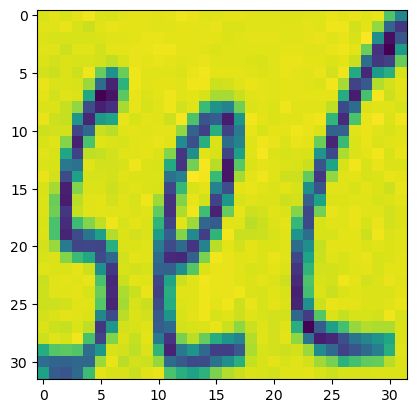

Label: \sec
Right label: \sec


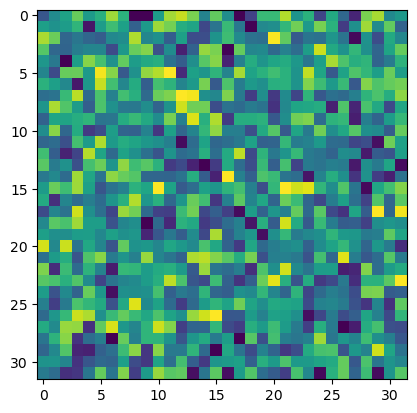

Label: empty
Right label: empty


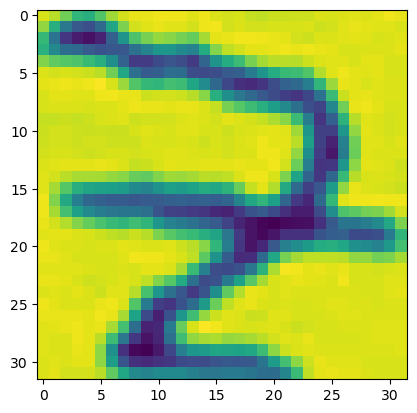

Label: z
Right label: z


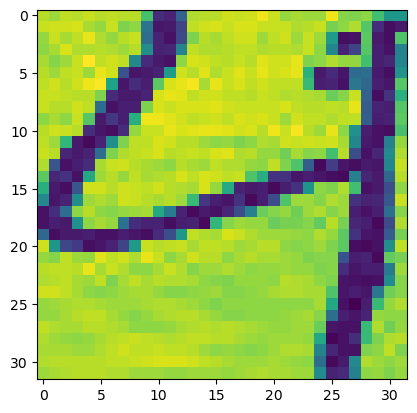

Label: 4
Right label: 4


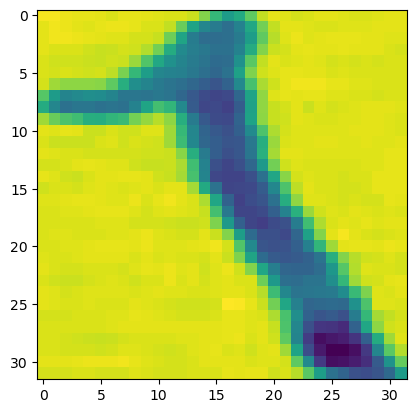

Label: 1
Right label: 1


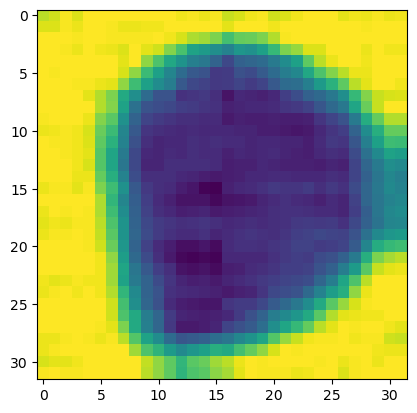

Label: .
Right label: \cdot


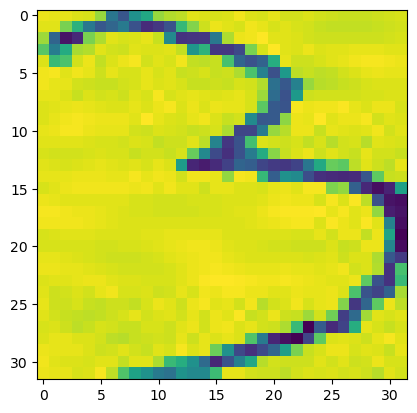

Label: 3
Right label: 3


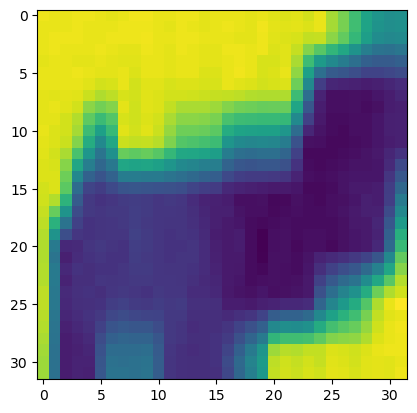

Label: -
Right label: -


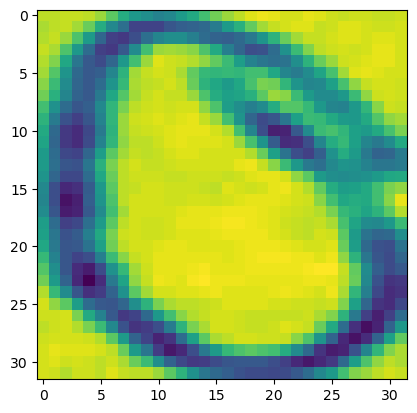

Label: 0
Right label: 0


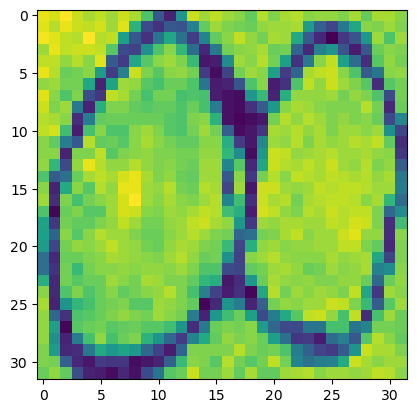

Label: \infty
Right label: \infty


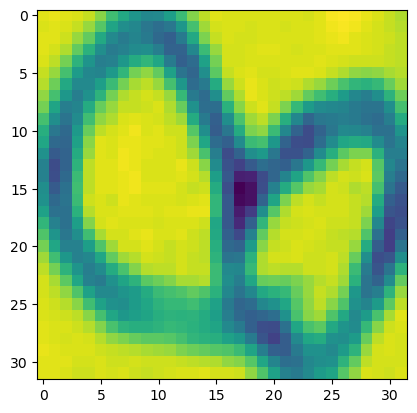

Label: \infty
Right label: \infty


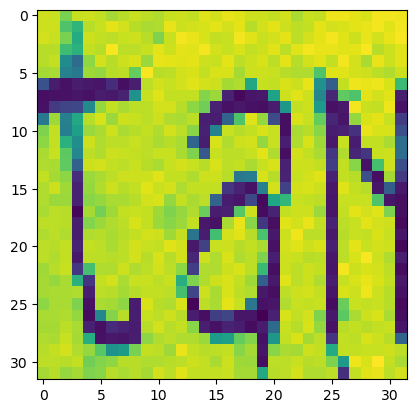

Label: \tan
Right label: \tan


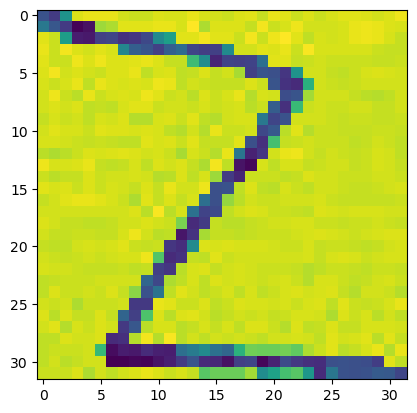

Label: z
Right label: z


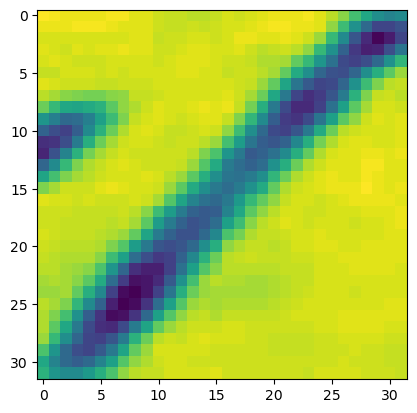

Label: 
Right label: 


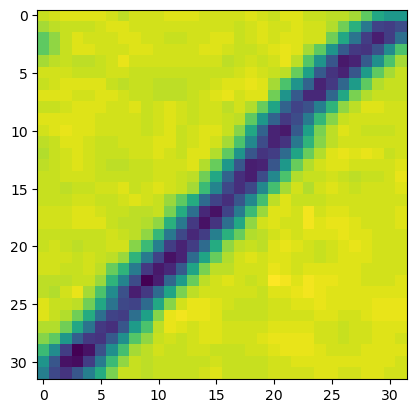

Label: 
Right label: 


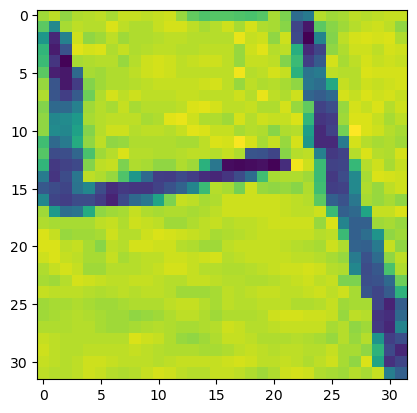

Label: 4
Right label: 4


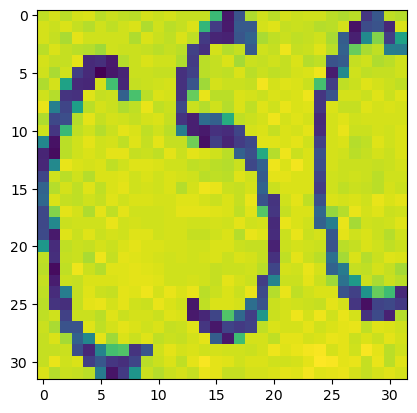

Label: \csc
Right label: \csc


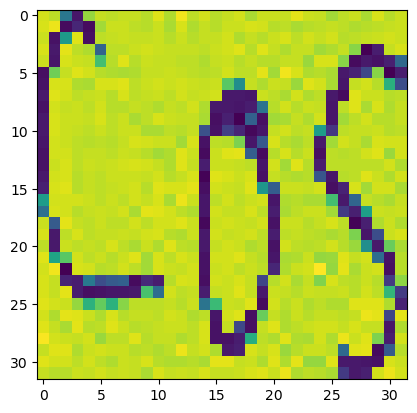

Label: \cos
Right label: \cos


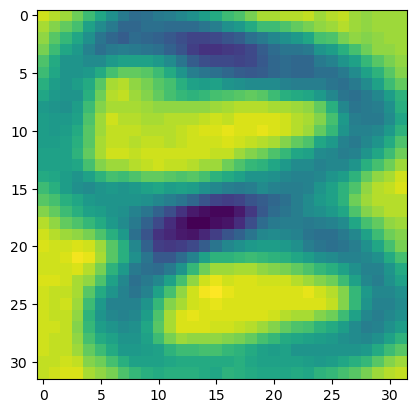

Label: 8
Right label: 8


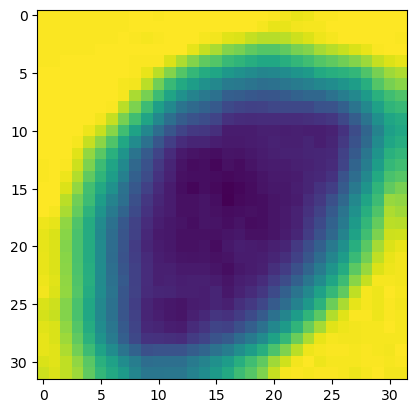

Label: \cdot
Right label: \cdot


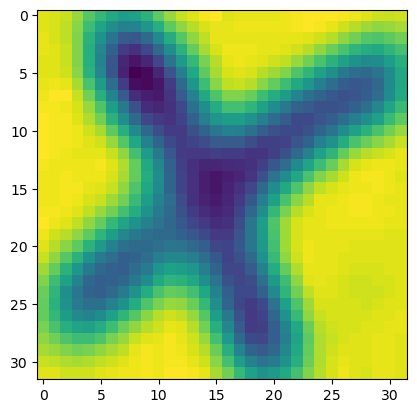

Label: x
Right label: x


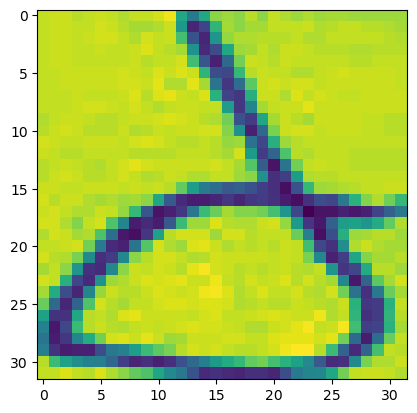

Label: d
Right label: d


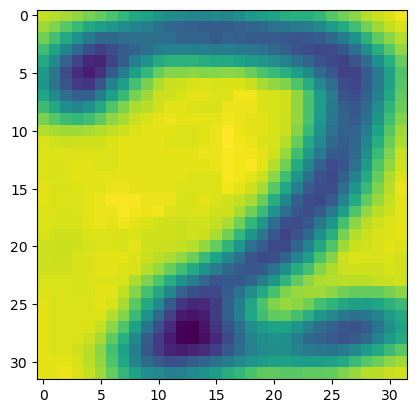

Label: 2
Right label: 2


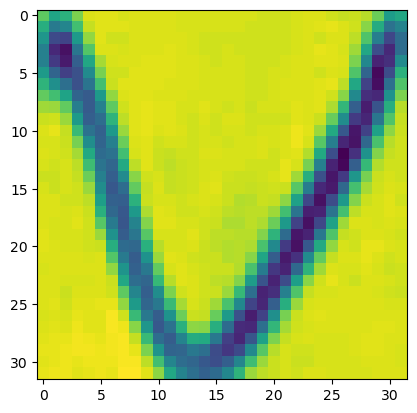

Label: v
Right label: v


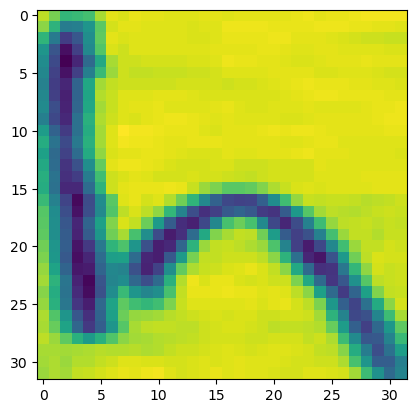

Label: h
Right label: h


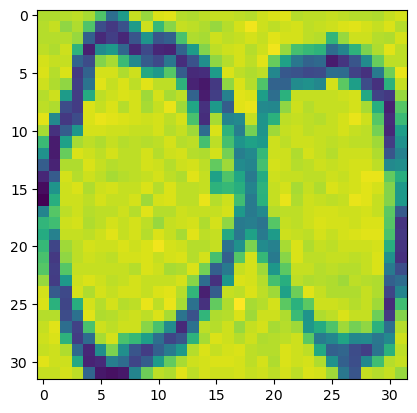

Label: \infty
Right label: \infty


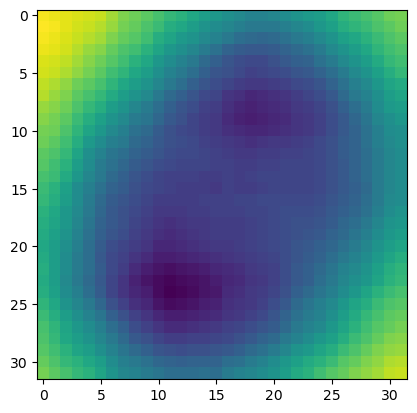

Label: .
Right label: .


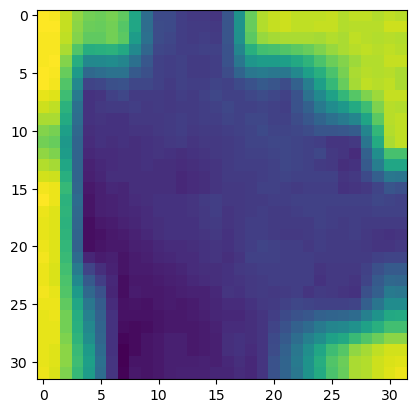

Label: \cdot
Right label: \cdot


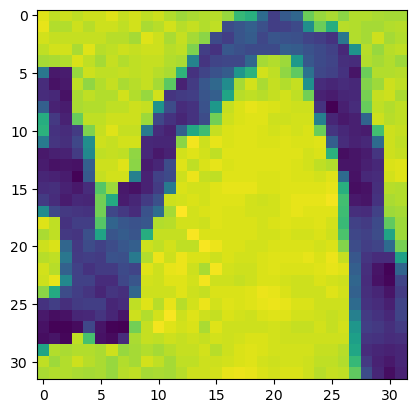

Label: n
Right label: n


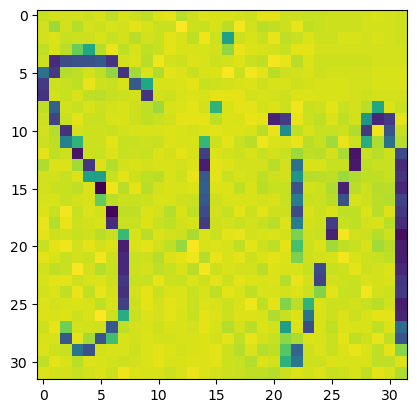

Label: \sin
Right label: \sin


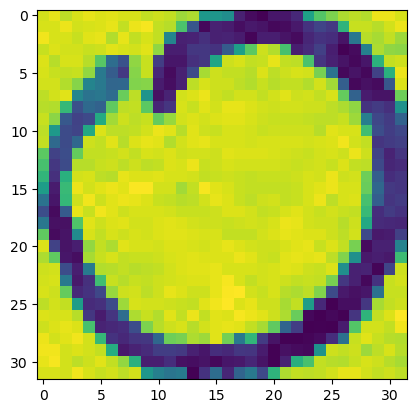

Label: 0
Right label: 0


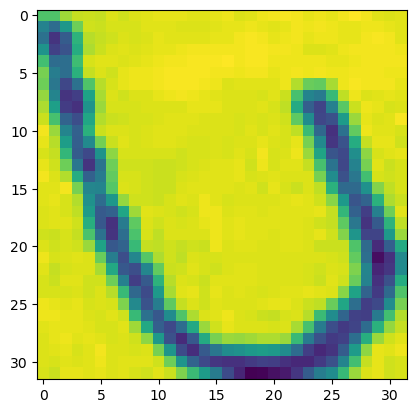

Label: u
Right label: u


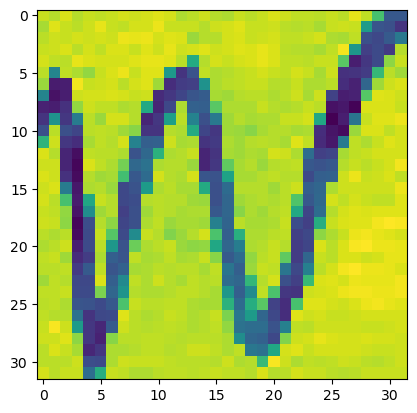

Label: w
Right label: w


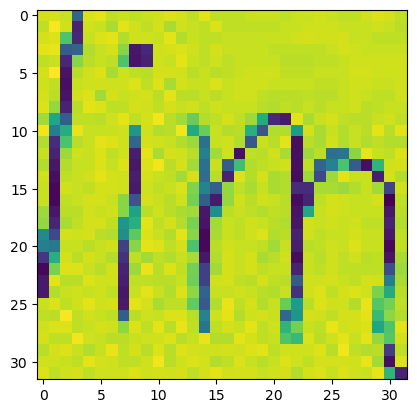

Label: \lim
Right label: \lim


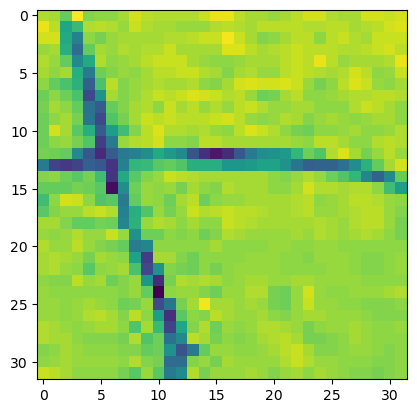

Label: t
Right label: t


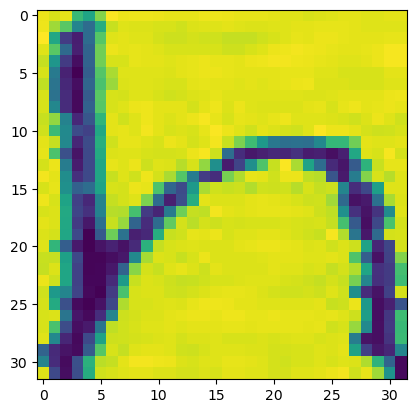

Label: h
Right label: h


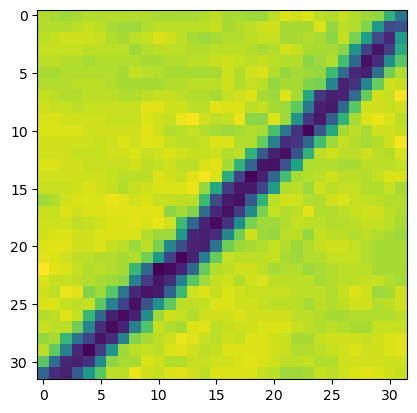

Label: 
Right label: 


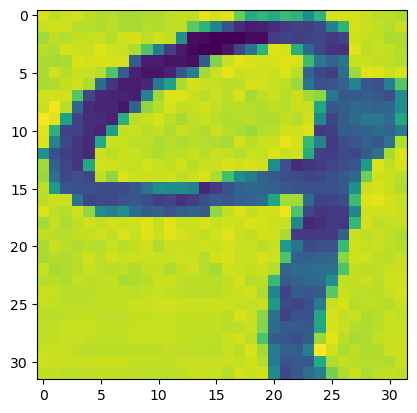

Label: 9
Right label: 9


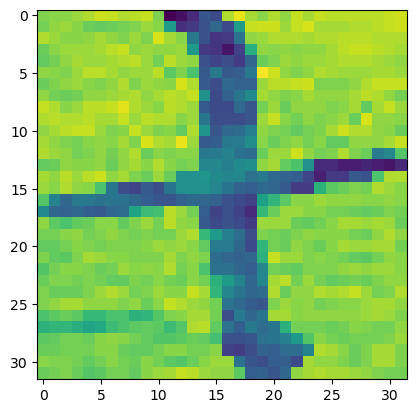

Label: t
Right label: t


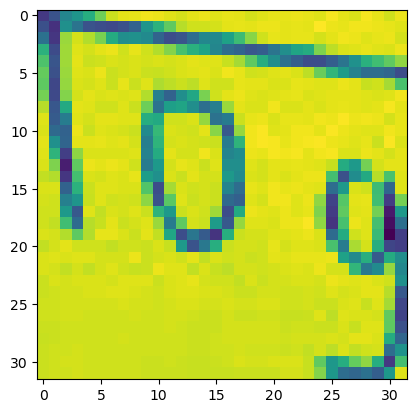

Label: \log
Right label: \log


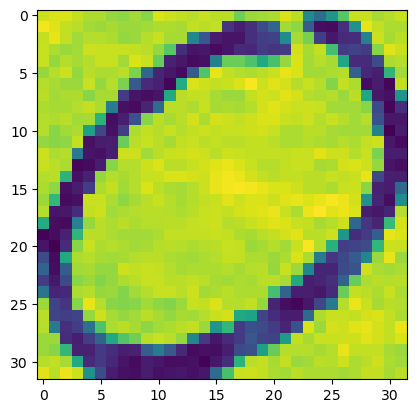

Label: 0
Right label: 0


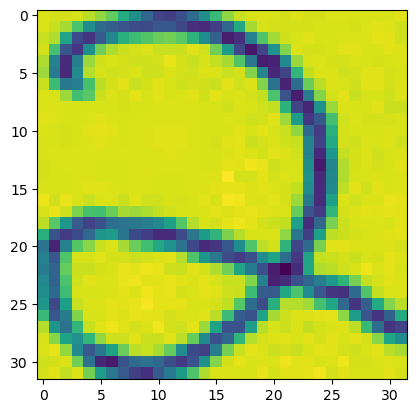

Label: 2
Right label: 2


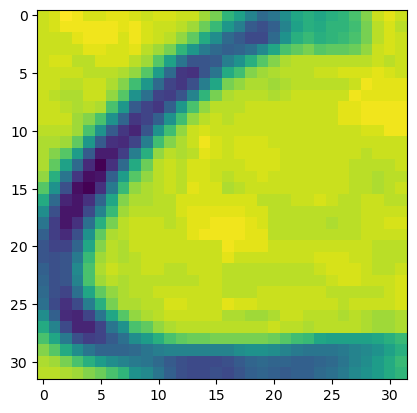

Label: c
Right label: c


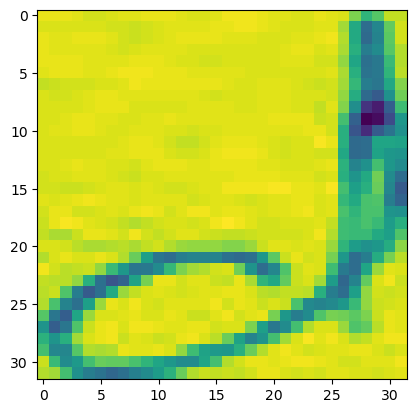

Label: d
Right label: d


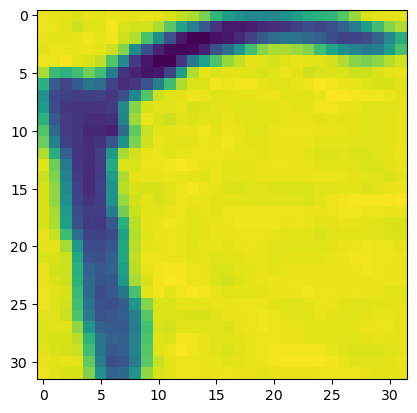

Label: r
Right label: r


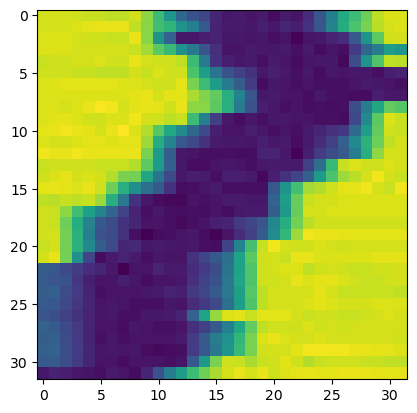

Label: \right|
Right label: \right|


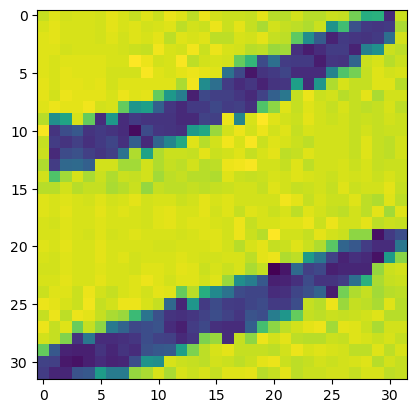

Label: =
Right label: =


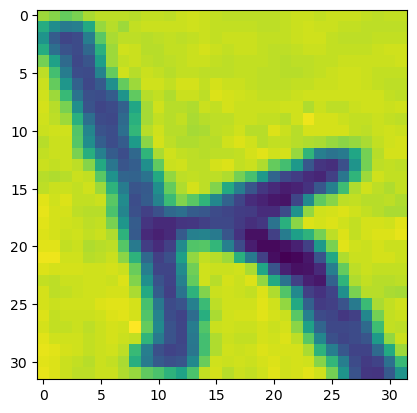

Label: k
Right label: k


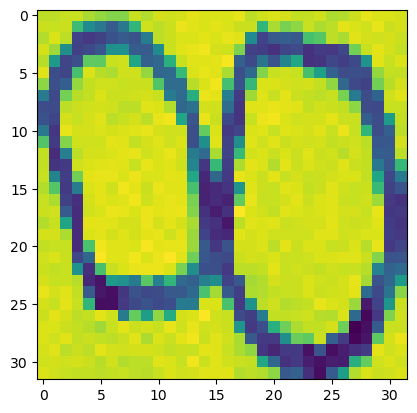

Label: \infty
Right label: \infty


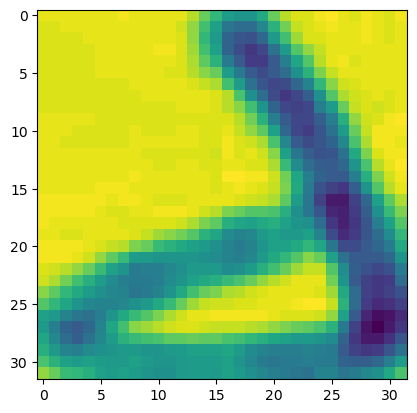

Label: d
Right label: d


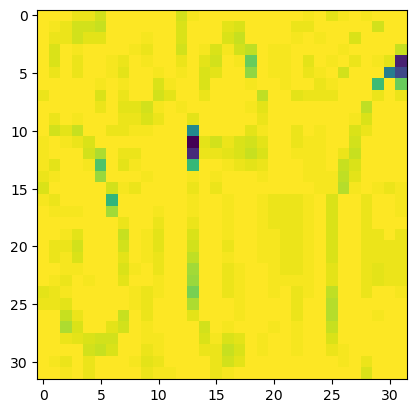

Label: \sec
Right label: \sec


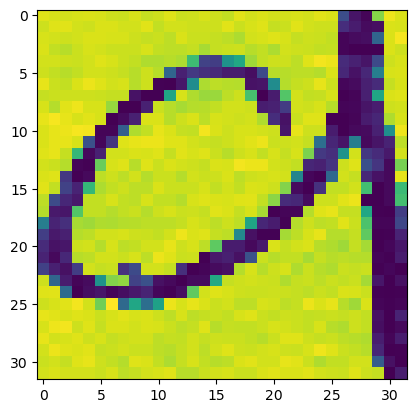

Label: d
Right label: d


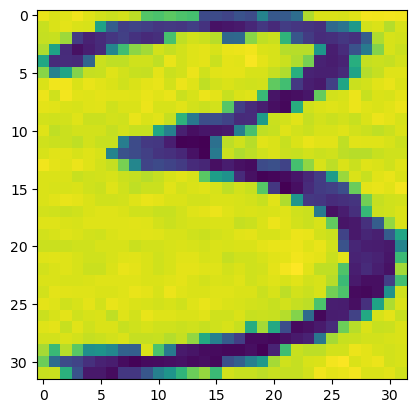

Label: 3
Right label: 3


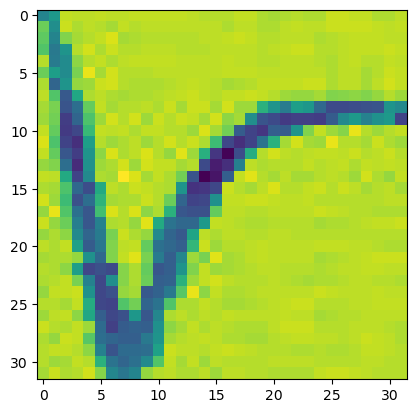

Label: r
Right label: r


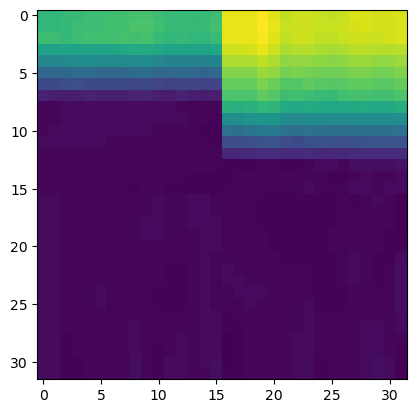

Label: \frac
Right label: \frac


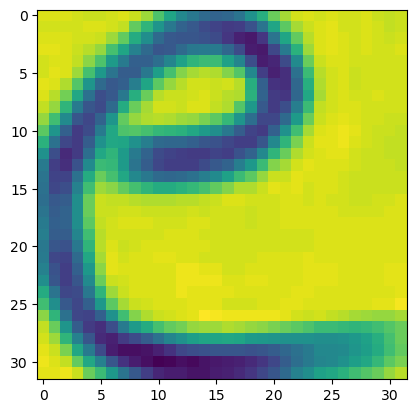

Label: e
Right label: e


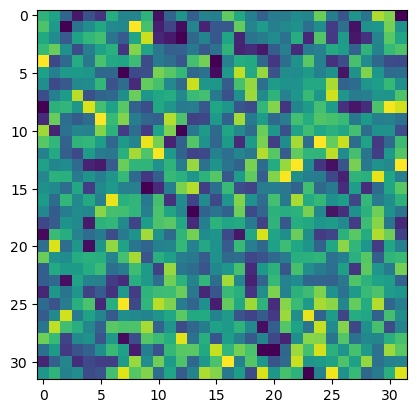

Label: empty
Right label: empty


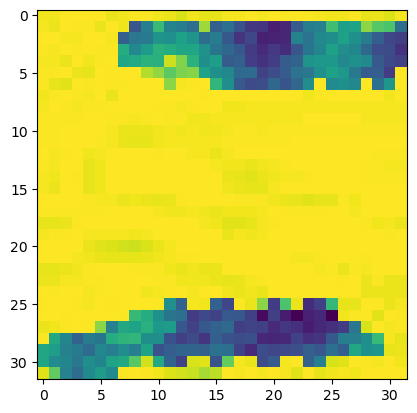

Label: =
Right label: =


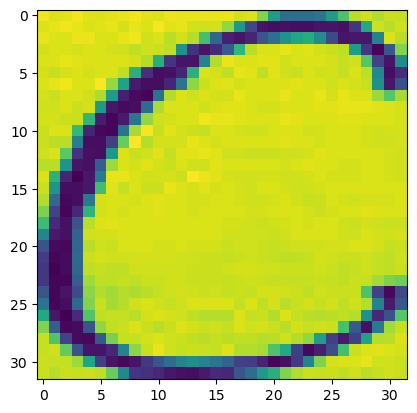

Label: c
Right label: c


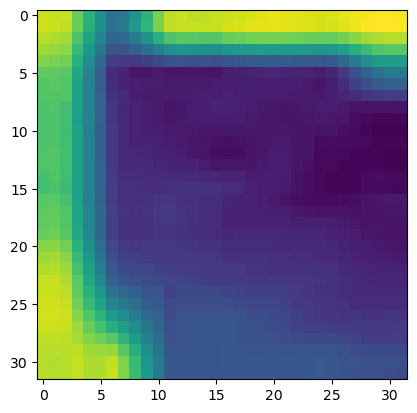

Label: \cdot
Right label: \cdot


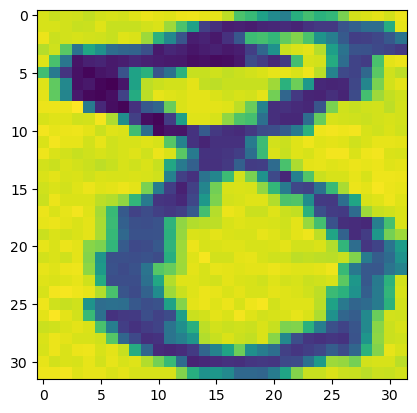

Label: 8
Right label: 8


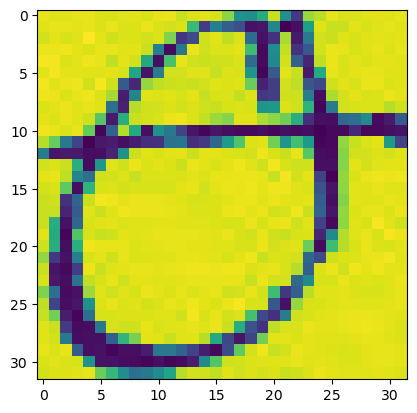

Label: \theta
Right label: \theta


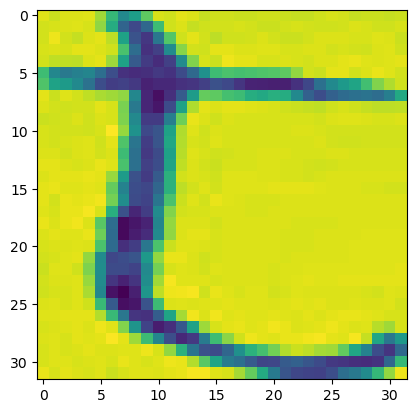

Label: t
Right label: t


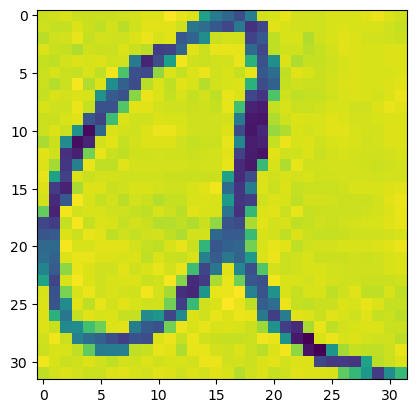

Label: a
Right label: a


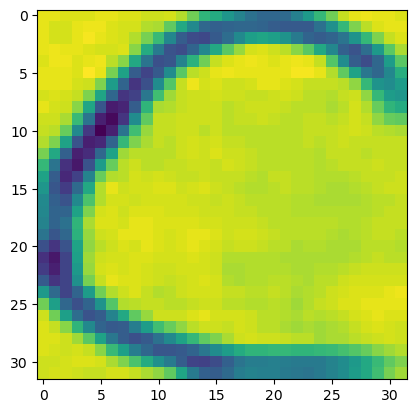

Label: c
Right label: c


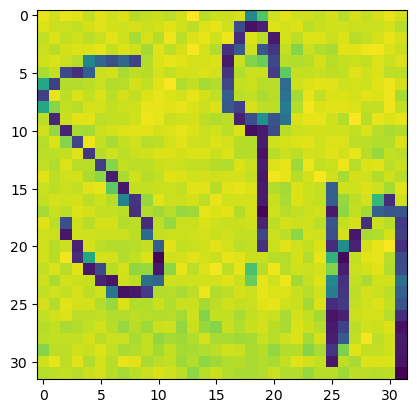

Label: \sin
Right label: \sin


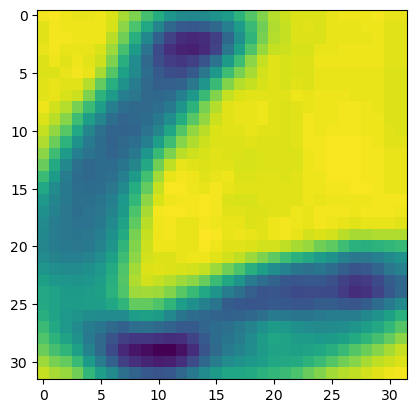

Label: 6
Right label: 6


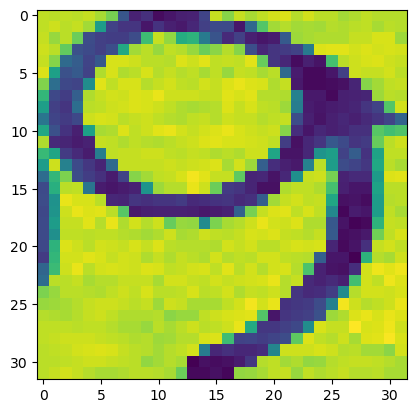

Label: g
Right label: 9


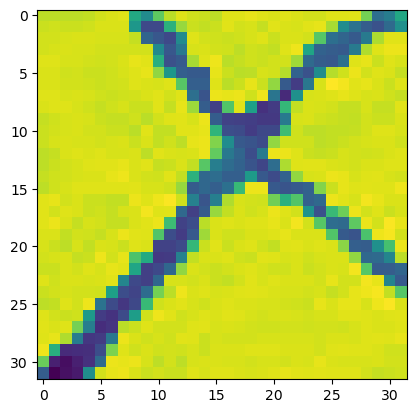

Label: x
Right label: x


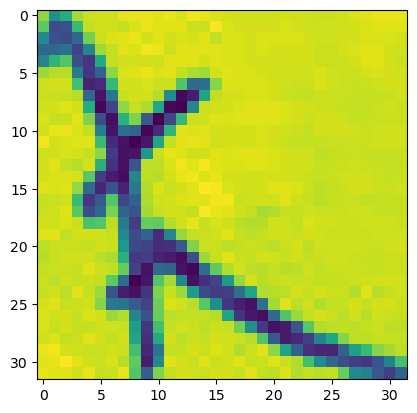

Label: k
Right label: k


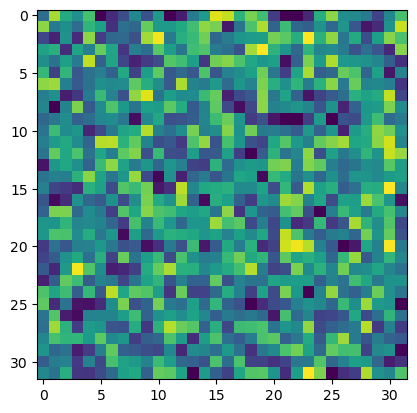

Label: empty
Right label: empty


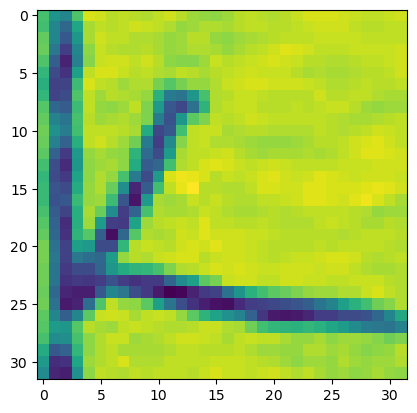

Label: k
Right label: k


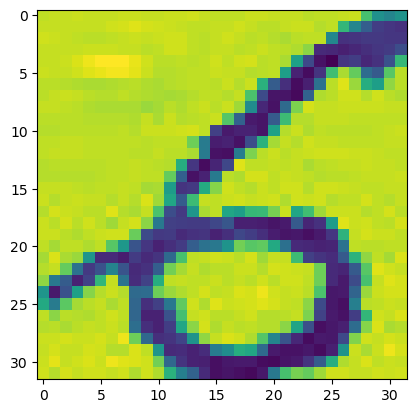

Label: 6
Right label: 6


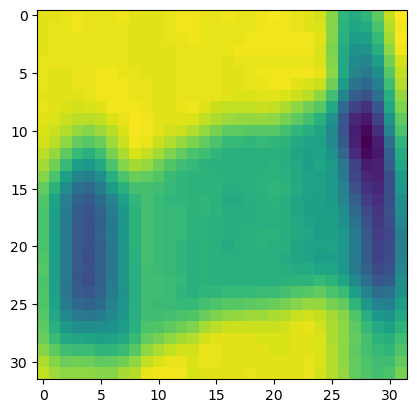

Label: \to
Right label: \to


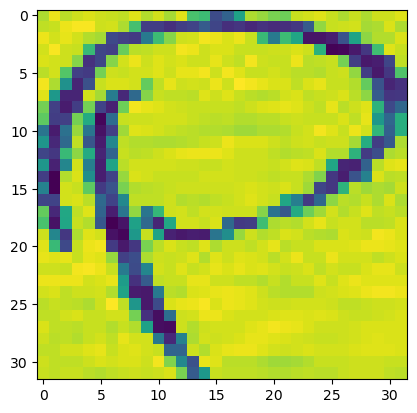

Label: p
Right label: p


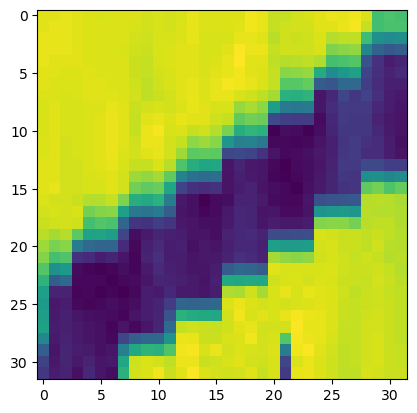

Label: -
Right label: \frac


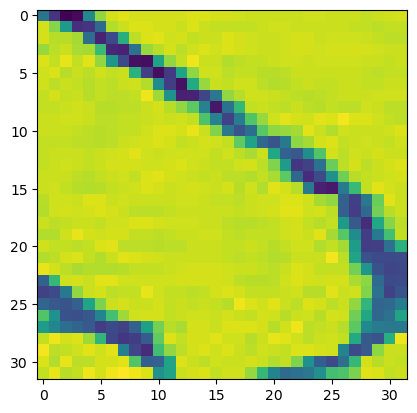

Label: \right)
Right label: \right)


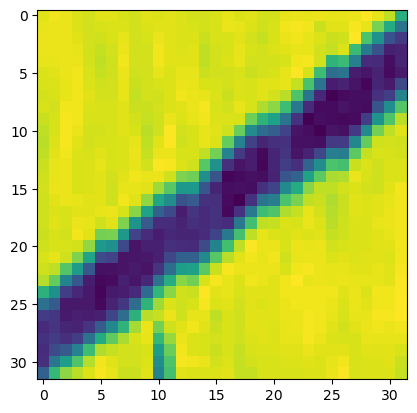

Label: \frac
Right label: \frac


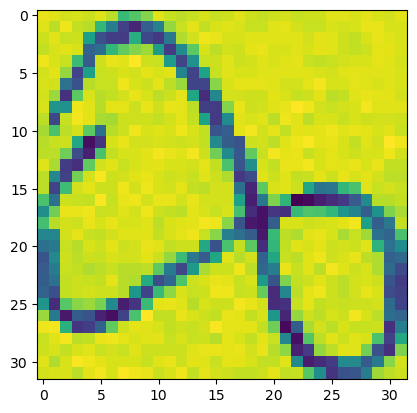

Label: \infty
Right label: \infty


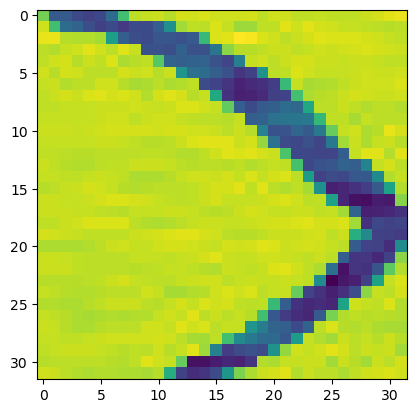

Label: \right)
Right label: \right)


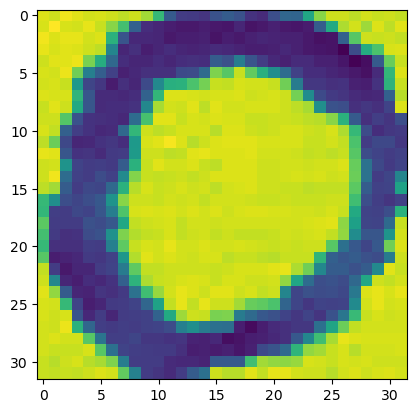

Label: 0
Right label: 0


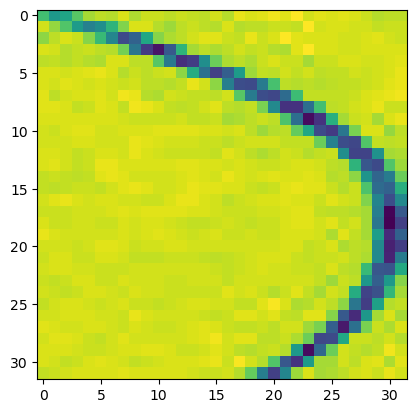

Label: \right)
Right label: \right)


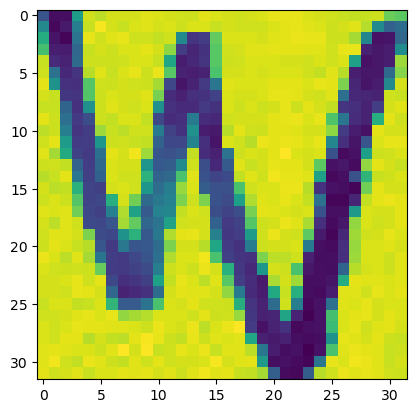

Label: w
Right label: w


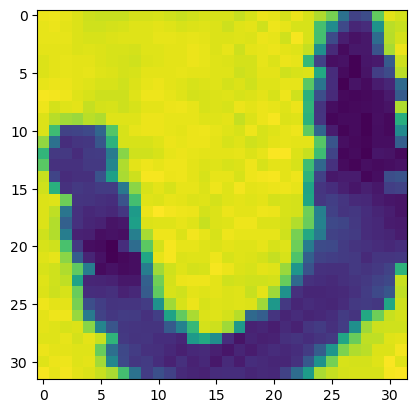

Label: v
Right label: v


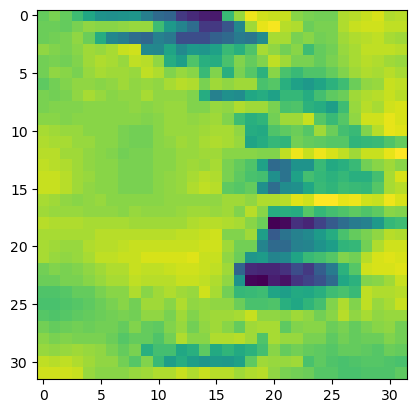

Label: \right|
Right label: \left|


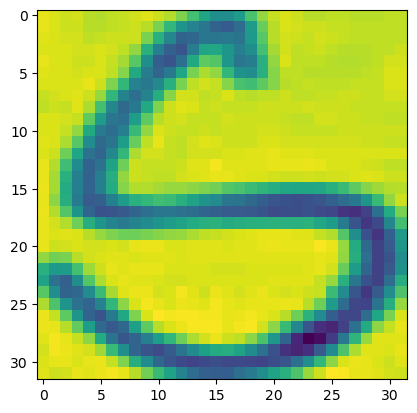

Label: s
Right label: s


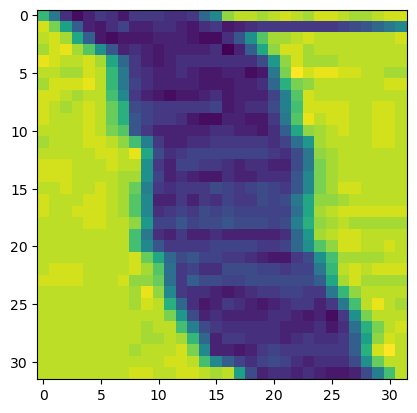

Label: \right|
Right label: \right|


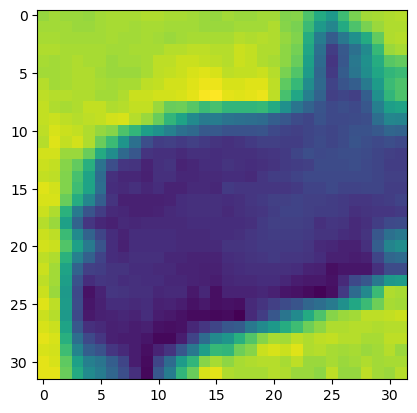

Label: .
Right label: .


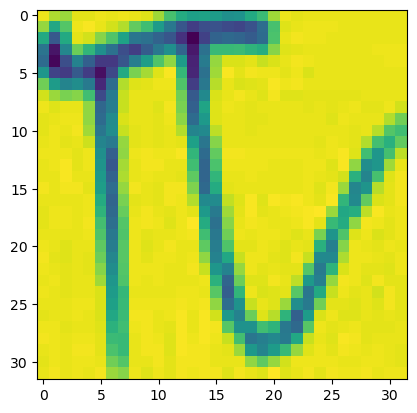

Label: \pi
Right label: \pi


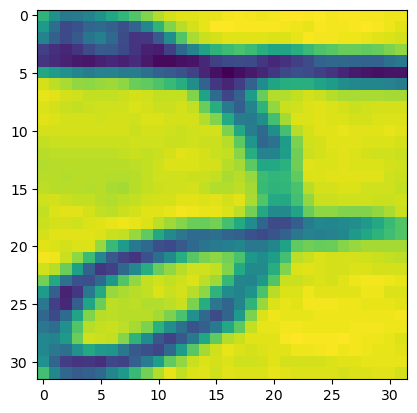

Label: =
Right label: 2


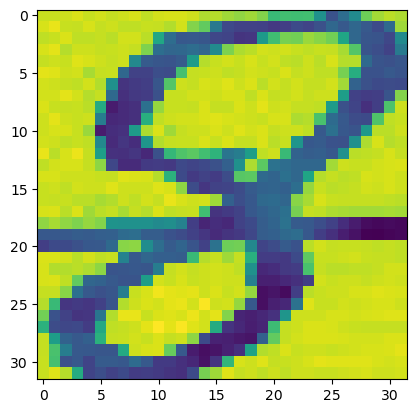

Label: 8
Right label: 8


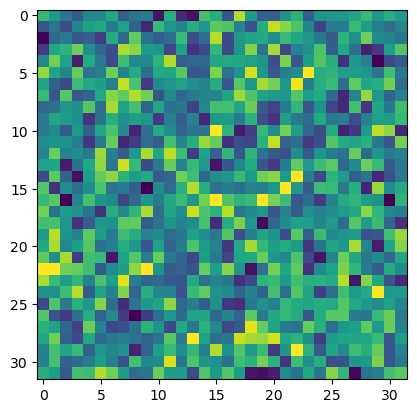

Label: empty
Right label: empty


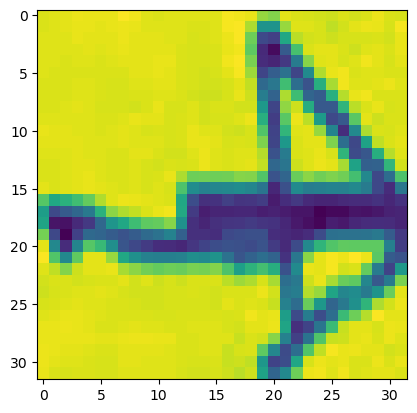

Label: \to
Right label: \to


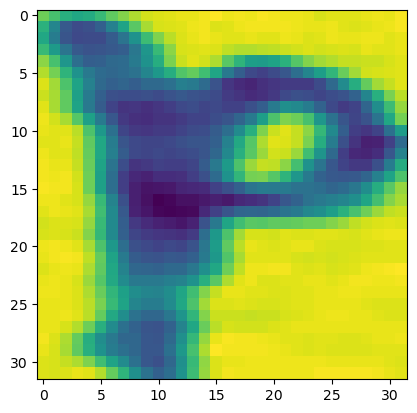

Label: p
Right label: p


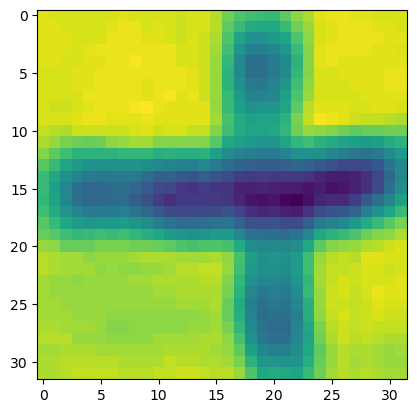

Label: +
Right label: +


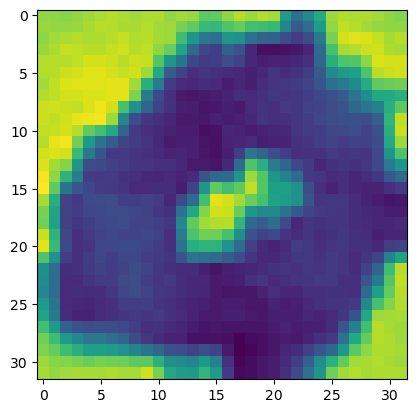

Label: \cdot
Right label: \cdot


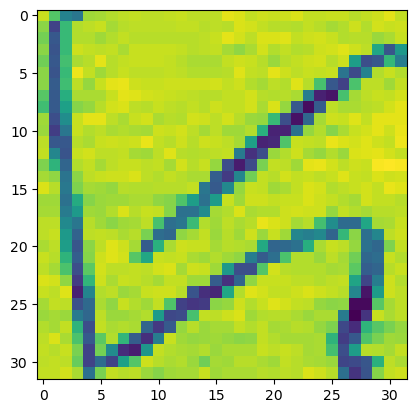

Label: k
Right label: k


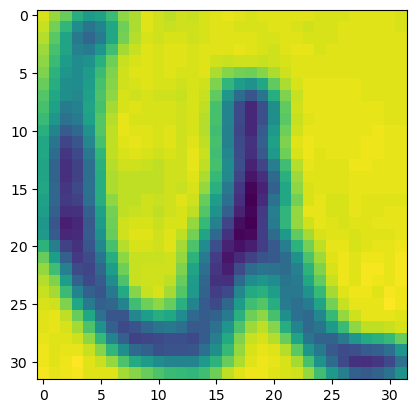

Label: u
Right label: u


In [222]:
for j in range(100):
    img = test_features.cpu()[j].squeeze()
    label = test_labels.cpu().view([-1,55])[j]
    plt.imshow(img[0])
    plt.show()
    print(f"Label: {list(amount_examples_chars.keys())[torch.argmax(results.cpu().view([-1,55])[j]).item()]}")
    print(f"Right label: {list(amount_examples_chars.keys())[torch.argmax(test_labels.cpu().view([-1,55])[j]).item()]}")